# Practice Exercise 1 ("due" October 14)

In [82]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
from scipy.linalg import expm

## Question 1: Generating entanglement 

Bell states are foundational to quantum information science and represent the simplest examples of entangled states. The four Bell states are typically denoted

$$\vert \Phi^+\rangle=\frac{1}{\sqrt{2}}\left(\vert 00\rangle+\vert 11\rangle\right),$$
$$\vert \Phi^-\rangle=\frac{1}{\sqrt{2}}\left(\vert 00\rangle-\vert 11\rangle\right),$$
$$\vert \Psi^+\rangle=\frac{1}{\sqrt{2}}\left(\vert 01\rangle+\vert 10\rangle\right),$$
$$\vert \Psi^-\rangle=\frac{1}{\sqrt{2}}\left(\vert 01\rangle-\vert 10\rangle\right).$$

The following Qiskit code generates a quantum circuit that prepares the Bell state $\vert \Phi^+\rangle$:

In [83]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)
qc.measure([0,1],[0,1])
qc.draw()

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

We can sample the measurement outcomes using the ```AerSimulator```:

In [84]:
backend = AerSimulator()
job = backend.run(qc, shots=2048)

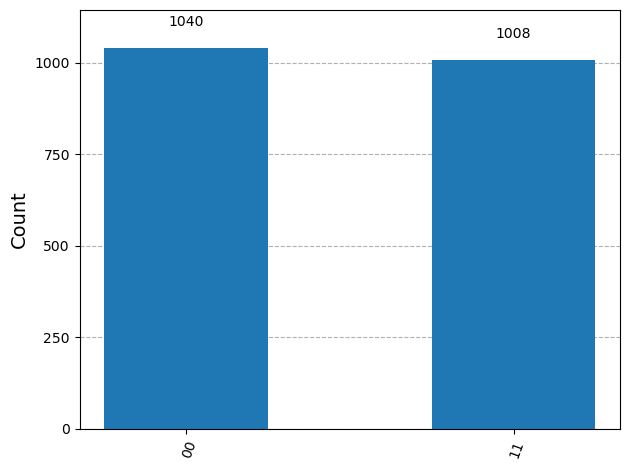

In [85]:
output = job.result()
counts = output.get_counts()
plot_histogram(counts)

The measurement above measured both qubits, prepared in $\vert \Phi^+\rangle$, in the $Z$ basis. Ask yourself if the measurement outcomes make sense.

**TO DO**: Write a circuit that measures both qubits in the $X$ basis instead. We will then use ```AerSimulator``` to sample the measurement outcomes.

In [86]:
#Use this as a skeleton
qc2 = QuantumCircuit(2,2)

#Prepare |Psi^+> (do not alter)
qc2.h(0)
qc2.cx(0,1)

## YOUR CODE GOES HERE ###
qc2.h(0)
qc2.h(1)
qc2.measure([0,1],[0,1])
qc2.draw()

┌───┐     ┌───┐┌─┐   
q_0: ┤ H ├──■──┤ H ├┤M├───
     └───┘┌─┴─┐├───┤└╥┘┌─┐
q_1: ─────┤ X ├┤ H ├─╫─┤M├
          └───┘└───┘ ║ └╥┘
c: 2/════════════════╩══╩═
                     0  1

Run this cell to sample the output of your circuit and plot a histogram of the results. Vary the number of shots if you like.

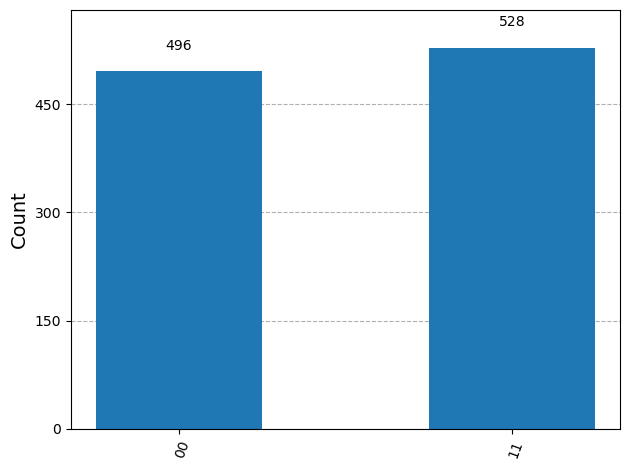

In [87]:
job = backend.run(qc2, shots=1024)
counts = job.result().get_counts()
plot_histogram(counts)

***TO DO*** If you've done this correctly, only certain measurement outcomes will be represented. Explain why (write your answer in this code cell below). It may help to think about the eigenstates of the Pauli-X operator, which you investigated in the last set of exercises. If you'd like to include equations in your explanation, you can have them render nicely by putting them inside dollar signs like this:$$1+1=2$$ 


***Your answer goes here***: The Bell state $\vert \Phi^+\rangle$ can be written as $\vert \Phi^+\rangle=(\vert ++\rangle+\vert --\rangle)/\sqrt{2}$, where $\vert\pm\rangle=(\vert 0\rangle\pm \vert 1\rangle)/\sqrt{2}$. An $X$-basis measurement measures a qubit in the basis $\vert\pm\rangle$. The measurement outcomes are therefore correlated, same as in the case of $Z$-basis measurements. 

# Question 2: Fun with Hadamards

Recall that the Hadamard matrix is given by $$H=\frac{1}{\sqrt{2}}\left[\begin{matrix}1 & 1\\
1 & -1\end{matrix}\right].$$

Single-qubit gates can be interpreted as rotations on the Bloch sphere. A rotation of the qubit by angle $\theta$ about the axis pointing along the unit vector $\hat{n}=(n_x,n_y,n_z)$ can be expressed as the unitary

$$U=e^{i\theta \hat{n}\cdot \vec{\sigma}},$$

where $\vec{\sigma}=(X,Y,Z)$ is a vector of Pauli matrices. For the Hadamard gate, we have

$$H = e^{i\varphi}U$$

for some choice of $\theta$, $\varphi$, and $\hat{n}$. What are the values of these parameters? Recall that unit vectors must satisfy the normalization condition $n_x^2+n_y^2+n_z^2=1$ by definition. A useful identity is that

$$e^{i\theta \hat{n}\cdot \vec{\sigma} }=\cos{\theta} I + i \sin{\theta}(\hat{n}\cdot \vec{\sigma}),$$

where $I$ is the $2\times 2$ identity matrix.

In [10]:
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1.j],[1.j,0]])
Z = np.array([[1,0],[0,-1]])

H = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])

In [11]:
def rotation(n, theta, varphi):

    "ARGS: unit vector n=[nx,ny,nz], theta, varphi"
    n_dot_sigma=(n[0]*X + n[1]*Y + n[2]*Z)
    U = expm(1.j*theta*n_dot_sigma)
    rot = np.exp(1.j*varphi)*U
    return rot
    

***TO DO*** Fill in your answer here. If your answer is correct the cell will return ```True```: 

In [12]:
your_Hadamard = rotation([1/np.sqrt(2), 0, 1/np.sqrt(2)], np.pi/2, -np.pi/2)
np.allclose(H, your_Hadamard)

True

# Question 3: Trotterization

The Hadamard can be constructed from `rx` and `rz` operations as

$$ R_x(\theta) = e^{i\frac{\theta}{2} X}, ~~~ R_z(\theta) = e^{i\frac{\theta}{2} Z},\\ H \equiv \lim_{n\rightarrow\infty} \left( ~R_x\left(\frac{\theta}{n}\right) ~~R_z \left(\frac{\theta}{n}\right) ~\right)^n$$

for some suitably chosen $\theta$. When implemented for finite $n$, the resulting gate will be an approximation to the Hadamard whose error decreases with $n$.

The following shows an example of this implemented with Qiskit with an incorrectly chosen value of $\theta$ (and with the global phase ignored).

* Determine the correct value of $\theta$.

* Show that the error (when using the correct value of $\theta$) decreases quadratically with $n$.

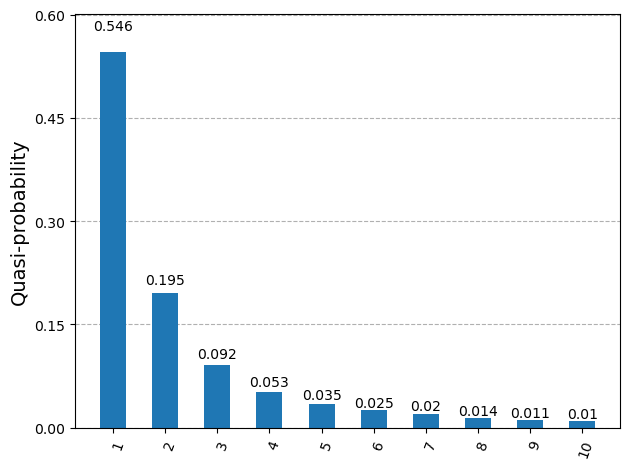

In [74]:
error = {}
for n in range(1,11):

    qc = QuantumCircuit(1,1)
    
    # Implement the Trotterized Hadamard

    ### YOUR ANSWER GOES HERE
    theta = np.pi/np.sqrt(2)
    ###

    for j in range(n):
        qc.rx(theta/n,0)
        qc.rz(theta/n,0)
      
    # We need to measure how good the above approximation is. Here's a simple way to do this.
    # Step 1: Use a real Hadamard to cancel the above approximation.
    # For a perfect approximation, the qubit will return to its initial state (0) since H squares to the identity. 
    qc.h(0)
    
    # Step 2: Run the circuit, and see how many times we get the outcome 1. The fraction of 1s is a measure of the error.
    qc.measure(0,0)
    shots = 100000
    job = backend.run(qc, shots=shots) 
    try:
        error[n] = (job.result().get_counts()['1']/shots)
    except:
        pass
        
plot_histogram(error)

In terms of showing that the scaling is (...or isn't) quadratic, you can do this however you like, but one possibility is to look into fitting functions like numpy's ```polyfit```. If it's helpful, you can convert the error data from a dictionary to a list like this:

In [75]:
n_vals = []
error_vals = []
for key, val in error.items():
    n_vals.append(key)
    error_vals.append(val)

***Sample solution***: Errors due to Trotterization scale quadratically because for noncommuting matrices, we have $$e^{\Delta t(A+B)}=e^{\Delta t A}e^{\Delta t B}e^{-\frac{\Delta t^2}{2}[A,B] + h.o.t.'s}.$$ This is the well-known Baker-Campbell-Hausdorff formula. Since the time slice $\Delta t$ scales like $1/n$, errors due to the commutator (neglected when we Trotterize) scale like $1/n^2$. 

If the error for $n$ Trotter steps scales like $$\mathrm{error}(n)=k/n^2 + c,\quad k,c=constants,$$
then we can extract $k$ and $c$ from a linear fit $y=kx + c$ with $x=1/n^2$. The following code finds and plots the resulting fit.

In [76]:
def inverse_quad(n):
    return 1/n**2

In [77]:
degs = np.polyfit(inverse_quad(np.array(n_vals)), error_vals, 1)
polynomial_fit = np.poly1d(degs)

In [78]:
import matplotlib.pyplot as plt

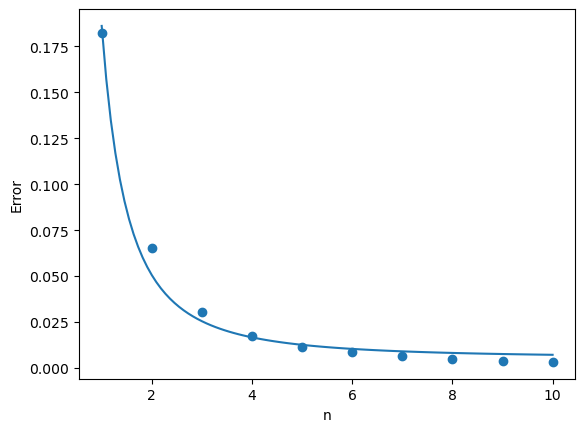

In [88]:
plt.scatter(n_vals, error_vals)
plt.plot(np.linspace(1,10,100), polynomial_fit(inverse_quad(np.linspace(1,10,100))))
plt.xlabel('n')
plt.ylabel('Error')
plt.show()